In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
set_config(transform_output = 'pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# sns.set_theme('notebook')
# sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
df = pd.read_csv('data/ab_data.zip', parse_dates=['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    290482 non-null  int64         
 1   timestamp  290482 non-null  datetime64[ns]
 2   group      290482 non-null  object        
 3   converted  290482 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 8.9+ MB


In [4]:
df

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1
...,...,...,...,...
290477,751197,2017-01-03,A,0
290478,945152,2017-01-12,A,0
290479,734608,2017-01-22,A,0
290480,697314,2017-01-15,A,0


In [5]:
daily_data = (
    df.groupby(['timestamp', 'group'])
    .agg({'user_id': 'count', 'converted': 'sum'})
    .reset_index()
    .rename(columns={'user_id': 'users_count'})
)
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


In [6]:
daily_data["conversion"] = daily_data.converted / daily_data.users_count * 100

Чему была равна конверсия (в процентах) в группе А 5 января 2017 года?

In [7]:
conv = daily_data[
    (daily_data["timestamp"] == "2017-01-05") & (daily_data["group"] == "A")
]["conversion"].values[0]
print(f"Конверсия для группы А 2017-01-05 составила {conv:.2f} %")

Конверсия для группы А 2017-01-05 составила 12.32 %


In [8]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    46 non-null     datetime64[ns]
 1   group        46 non-null     object        
 2   users_count  46 non-null     int64         
 3   converted    46 non-null     int64         
 4   conversion   46 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.9+ KB


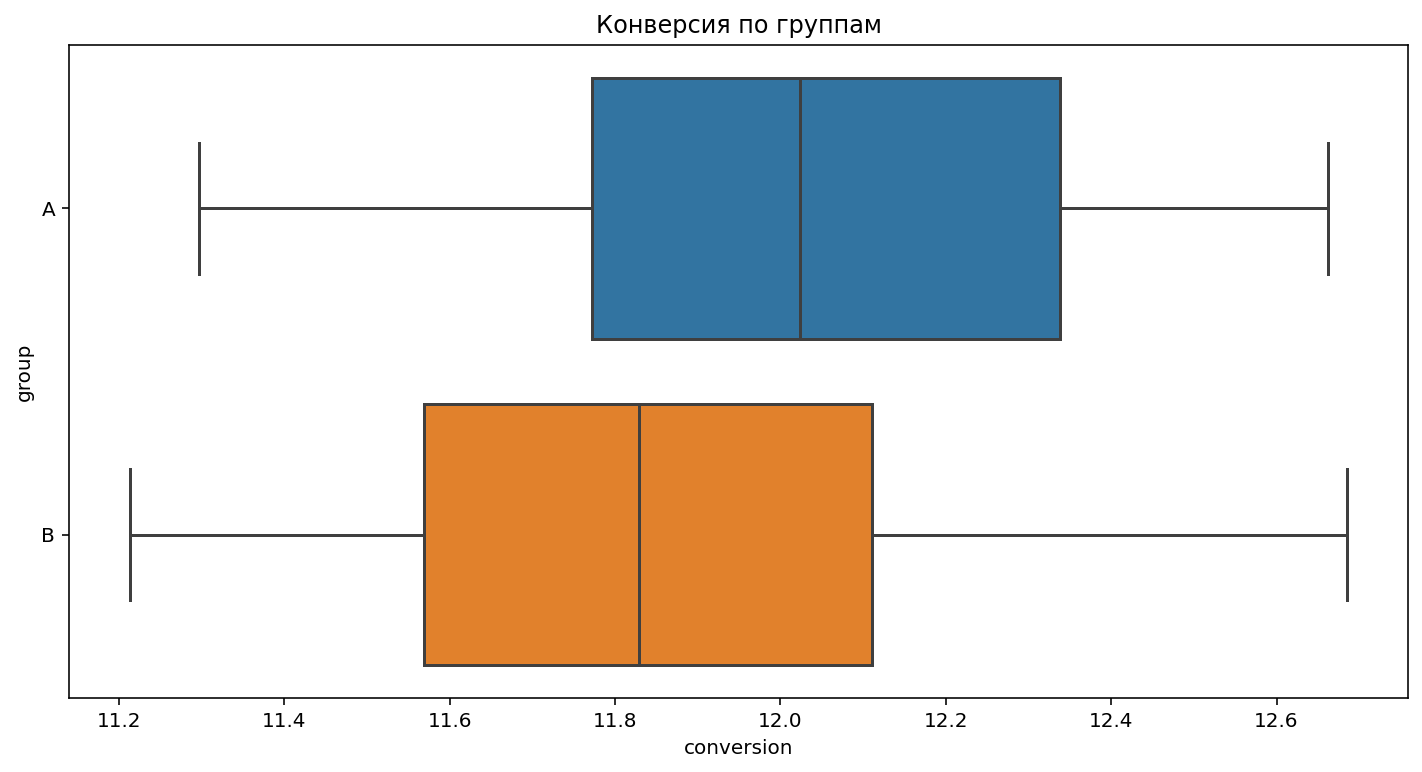

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax);
ax.set_title('Конверсия по группам');

In [10]:
conversion_piv = daily_data.groupby("group")["conversion"].agg(["mean", "median"])
conversion_piv

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Посмотрим, как вообще изменялись показатели ежедневной конверсии в каждой группе во времени

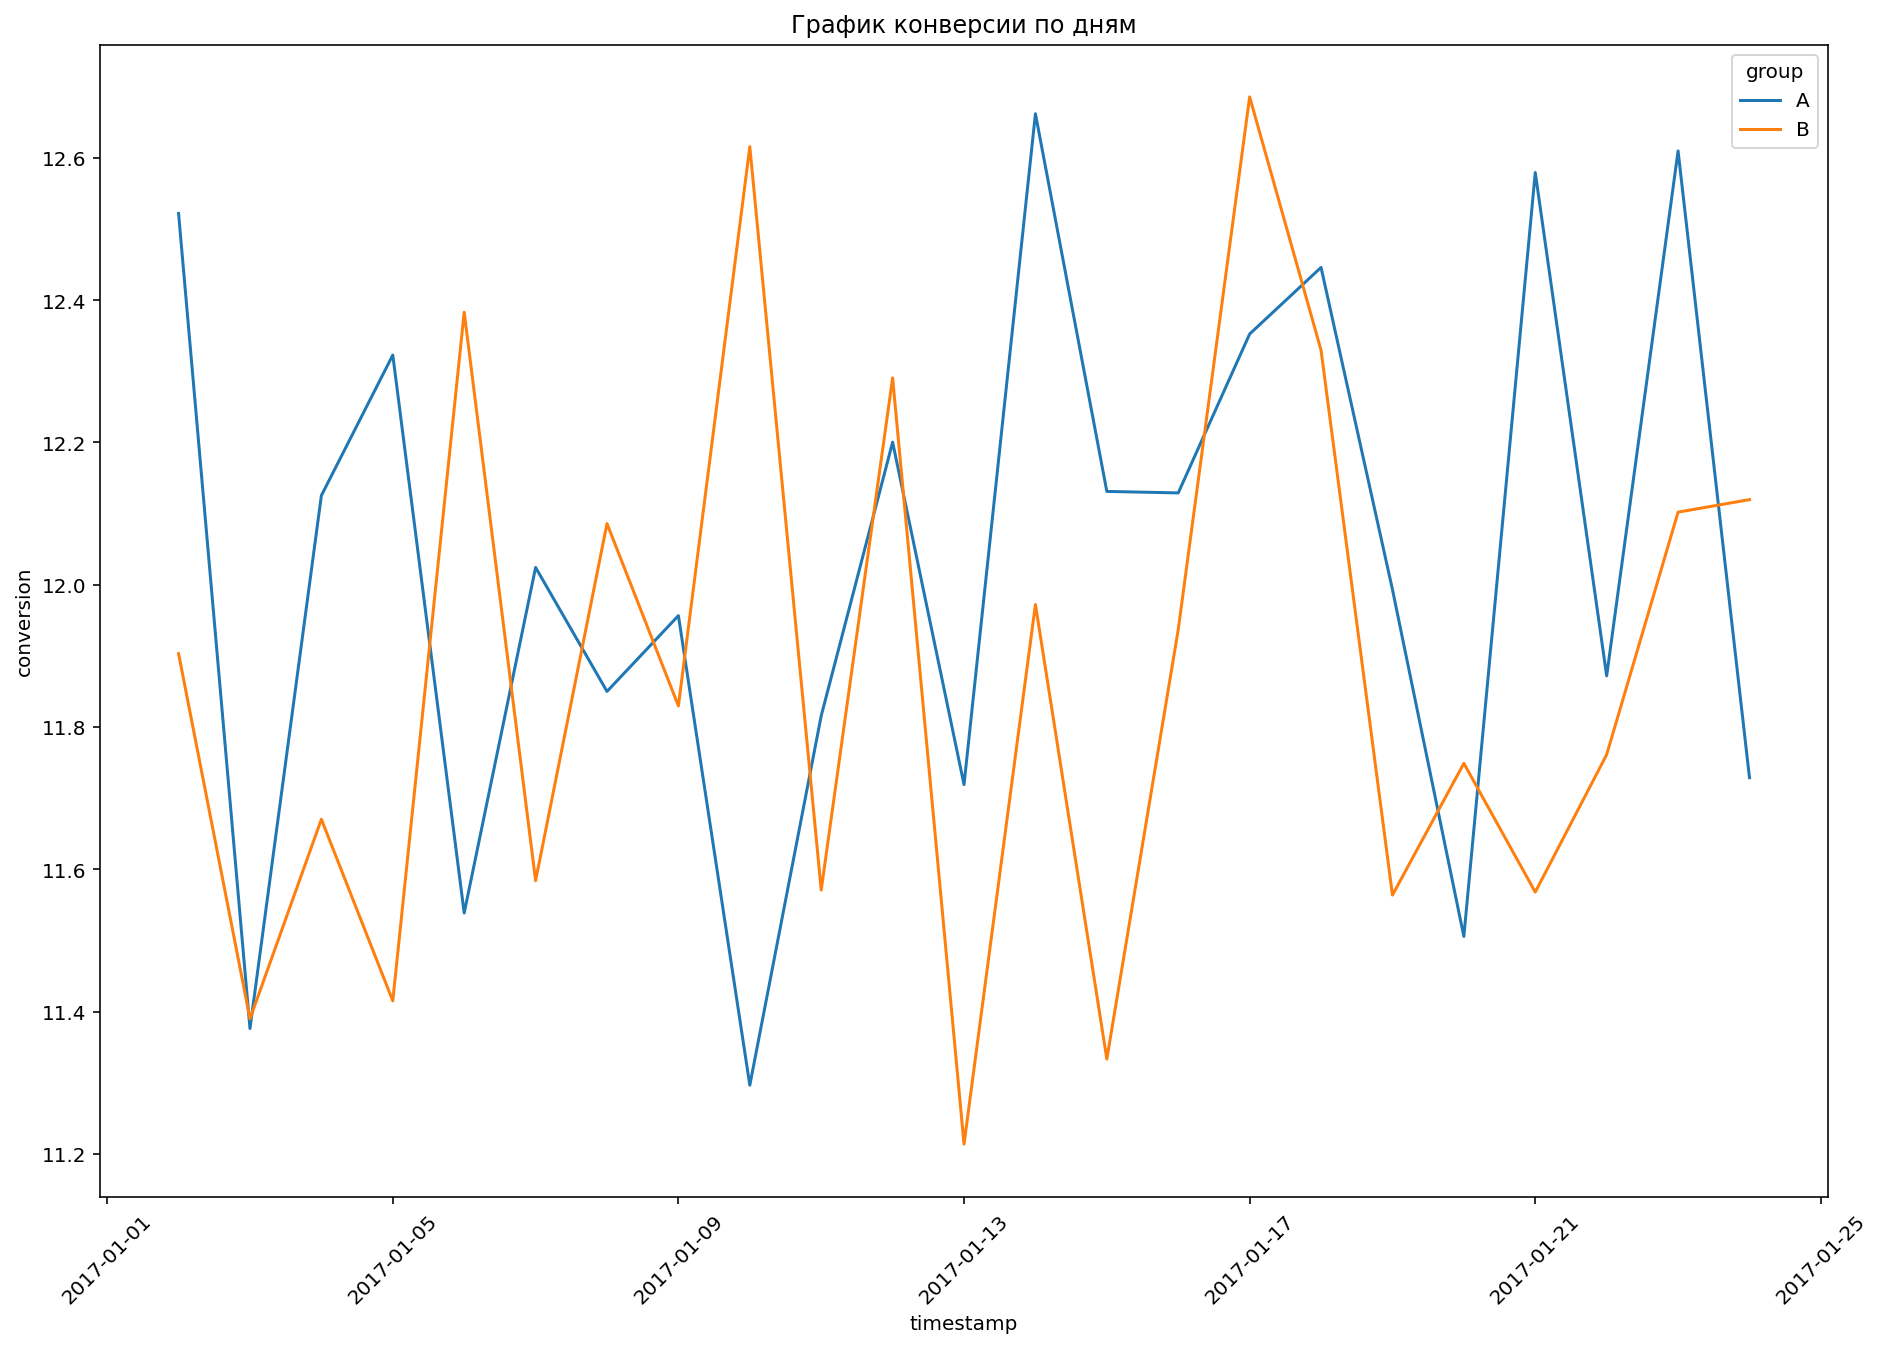

In [11]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
ax.set_title('График конверсии по дням')
ax.xaxis.set_tick_params(rotation=45)
# ax.grid(True);

### Расчет кумулятивных метрик

In [12]:
# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A'].copy()
# считаем кумулятивное количество посетителей
daily_data_a['cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
daily_data_a[['timestamp', 'users_count', 'cum_users_count']]

,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031
10,2017-01-07,6595,35626
12,2017-01-08,6692,42318
14,2017-01-09,6624,48942
16,2017-01-10,6657,55599
18,2017-01-11,6686,62285


In [13]:
# вычисляем кумулятивную сумму количества посетителей
daily_data["cum_users_count"] = daily_data.groupby(["group"])["users_count"].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data["cum_converted"] = daily_data.groupby(["group"])["converted"].cumsum()
# вычисляем кумулятивную конверсию
daily_data["cum_conversion"] = (
    daily_data["cum_converted"] / daily_data["cum_users_count"] * 100
)
daily_data

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806
5,2017-01-04,B,6538,763,11.670236,16006,1856,11.595652
6,2017-01-05,A,6419,791,12.322792,22427,2694,12.012307
7,2017-01-05,B,6509,743,11.414964,22515,2599,11.543416
8,2017-01-06,A,6604,762,11.538462,29031,3456,11.904516
9,2017-01-06,B,6735,834,12.383073,29250,3433,11.736752


Построим графики кумулятивной конверсии по дням в каждой группе

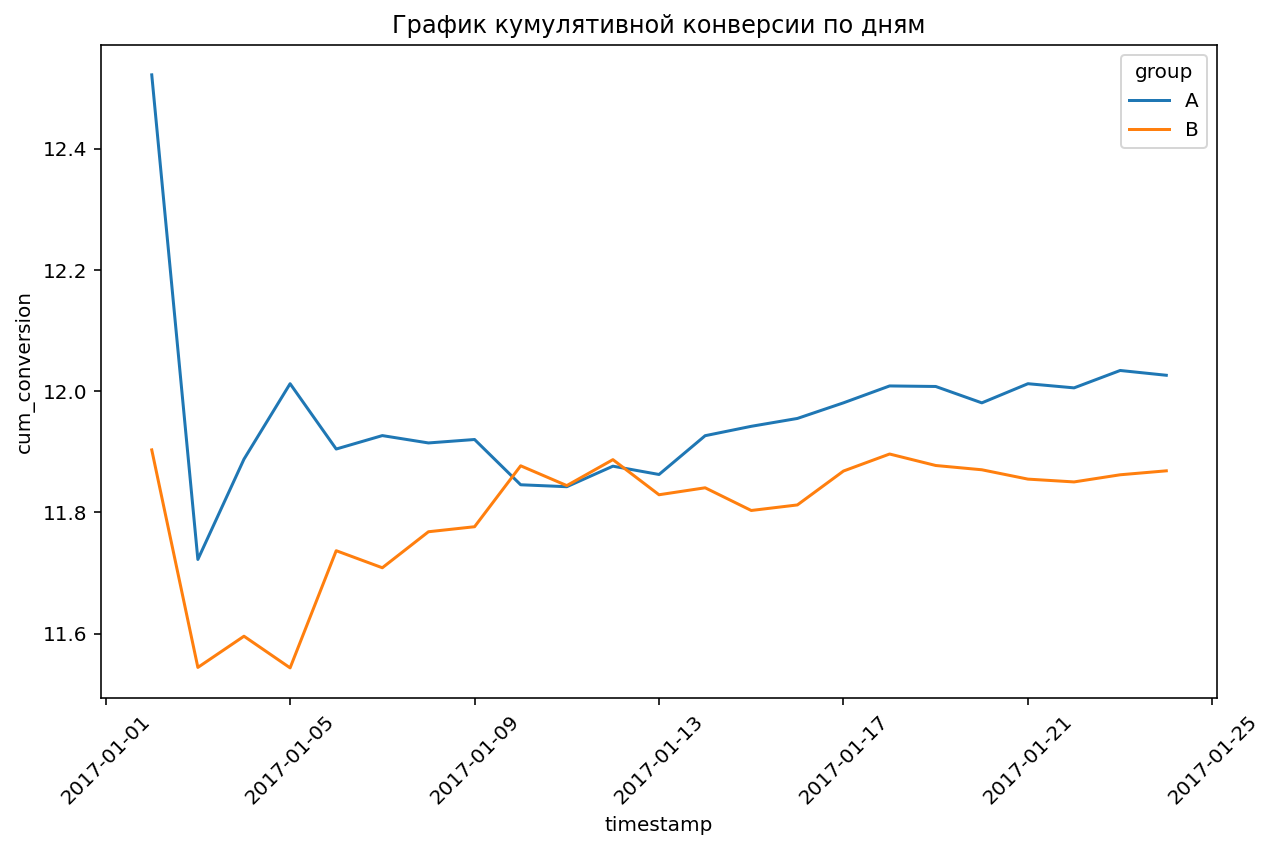

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation=45);